In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;  
}

<IPython.core.display.Javascript object>

In [2]:
import sys
sys.path.append('/Users/af/Work/code/mcmc/build')
#sys.path.append('/Users/af/Work/code/mcmc/debug')

import mcmc
#help(mcmc)
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt



['China' 'France' 'Italy' 'Korea, South' 'Spain' 'US']
DatetimeIndex(['2020-02-21', '2020-02-22', '2020-02-23', '2020-02-24',
               '2020-02-25', '2020-02-26', '2020-02-27', '2020-02-28',
               '2020-02-29', '2020-03-01', '2020-03-02', '2020-03-03',
               '2020-03-04', '2020-03-05', '2020-03-06', '2020-03-07',
               '2020-03-08', '2020-03-09', '2020-03-10', '2020-03-11',
               '2020-03-12', '2020-03-13', '2020-03-14', '2020-03-15',
               '2020-03-16', '2020-03-17', '2020-03-18', '2020-03-19',
               '2020-03-20', '2020-03-21', '2020-03-22', '2020-03-23',
               '2020-03-24', '2020-03-25', '2020-03-26', '2020-03-27',
               '2020-03-28', '2020-03-29', '2020-03-30', '2020-03-31',
               '2020-04-01', '2020-04-02', '2020-04-03', '2020-04-04',
               '2020-04-05', '2020-04-06', '2020-04-07', '2020-04-08',
               '2020-04-09', '2020-04-10', '2020-04-11', '2020-04-12'],
              dtype='

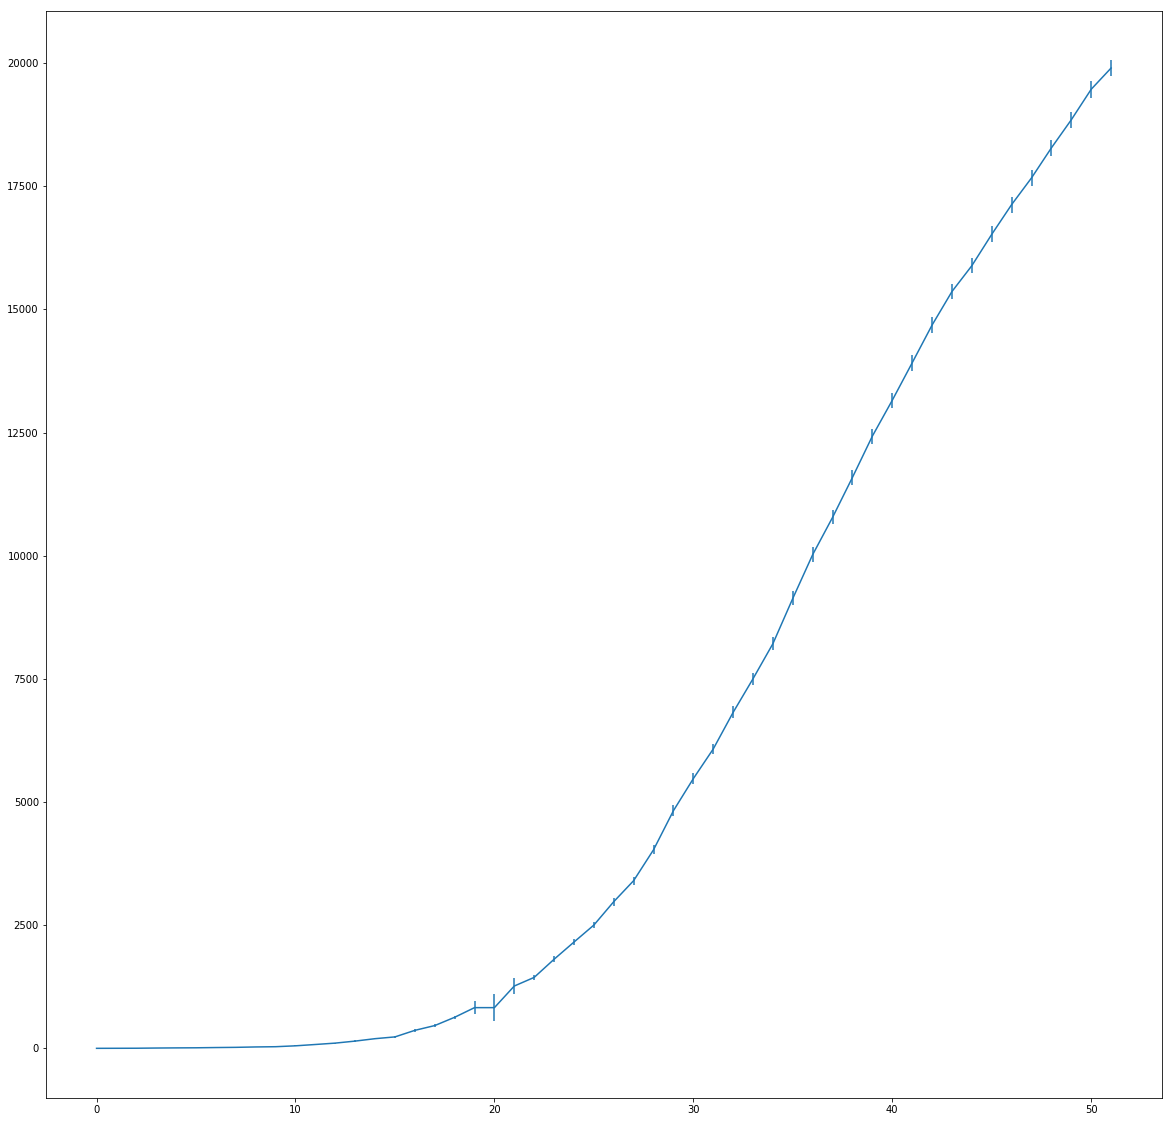

In [3]:
import pandas as pd
from datetime import datetime,timedelta
giturl_deaths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

corona_cases_df=pd.read_csv(giturl_deaths, index_col=[0,1,2,3])  
#   use first four columns as multiindex




country_official_list = (corona_cases_df.index.get_level_values('Country/Region').values)

wanted_countries = ['China', 'Korea','Italy', 'France', 'US', 'Spain']

countries_list = [np.unique(np.array([s for s in country_official_list if cou in s])) 
                                                 for cou in wanted_countries]
countries_list = np.array(countries_list).flatten()
countries_list.sort()
print(countries_list)


cases_percountry = {}
df_dict = {}
for country in countries_list:
    cou = corona_cases_df.loc[pd.IndexSlice[:, country], :].sum()
    cases_percountry[country] = cou[cou > 0]
    datesformat = [datetime.strptime(da, '%m/%d/%y') 
                   for da in cases_percountry[country].index]
    
    df_dict[country] = pd.DataFrame(cases_percountry[country], 
                                    columns=['Cases'], index=datesformat)
    df_dict[country]['DayCount'] = np.arange(1, 
                                             cases_percountry[country].shape[0]+1)
    
    
country = 'Korea, South'
country = 'Spain'
country = 'Italy'

print(df_dict[country].index)
#print(df_dict['Italy']['Cases'])  #print cases every three days

# for country in countries_list:
#     print(country)
#     dates=df_dict[country].index
#     plt.semilogy(dates, np.array(list(df_dict[country]['Cases'].values)), label=country)
#     plt.legend(loc='lower right')
#     plt.tick_params(rotation=45, labelsize=12)
#     #plt.ylabel(casestr, fontsize=14)
# plt.xlim([dates[0]-np.timedelta64(3,'D'), dates[-1]+np.timedelta64(10,'D')])
# plt.show()

if country == 'Italy':
    nPop = 60260000
    icuBeds = 7500
if country == 'Spain':
    nPop = 46722000
    icuBeds = 3500
if country == 'France':
    nPop = 67000000
    icuBeds = 7000
    
nPredictDays = 60
maxdelay = 40

#testdays = np.arange(60)

#starting at 21 feb 

#print(np.array(list(df_dict[country]['Cases'].values)))
deaths_data = np.array(list(df_dict[country]['Cases'].values))


#deaths_data = deaths_data[:-4]





#np.array([1,2,3,7,10,12,17,21,29,34,52,79,107,148,197,233,366,463,631,827,827,1266,1441,1809,2158,2503,2978,3405,4032,4825,5476,6077,6820,7503,8215,9134,10023,10779,11591,12428,13155,13915, 14681, 15362 ])
#nPop/(1+np.exp(-(testdays-20)*0.2))*0.0015

deaths_past = np.zeros(maxdelay + deaths_data.size)
deaths_past[maxdelay:] = deaths_data
#keep the relative error low at 1%. if all measurements were independent it would be low.
#but errors even out in time mostly - here we assume a tiny fraction of cases does not 
#besides the constant 

#shot noise: every delta has sigma = sqrt(delta). day i var is cumsum of sigma^2=delta, so the original total. 
#constant unnoticed deaths are fitted for
#assume additional 10% attribution error in the numbers of each day, which however are supposed to be cancelled by anticorrelated erros in 
#the next 2 days instead of accumulating 

shotnoise = np.sqrt(deaths_data)
deaths_error = shotnoise

perday = np.diff(deaths_data)
deaths_error[1:] += 0.05*perday 

#unnoticed = 3*np.ones(deaths_data.shape)
#unnoticed[14:] = 0
 #np.cumsum(unnoticed) + shotnoise

if country == 'Italy':
    deaths_error[19] += 100
    deaths_error[20] += 250
    deaths_error[21] += 100
    
    
time_past = np.arange(deaths_past.size)-maxdelay
time_data = np.arange(deaths_data.size)
time_all = np.arange(deaths_past.size+nPredictDays)-maxdelay


#plt.plot(time_past, deaths_past)
plt.figure(figsize=(20,20))
plt.errorbar(time_data, deaths_data, deaths_error)



deathdata = np.zeros((2, deaths_data.size))
deathdata[0, :] = deaths_data
deathdata[1, :] = deaths_error

if country == 'Italy':
    discontdays = np.array([1, 9, 12, 29]) #removed 32 
    discontvals = np.array([0.44,0.35,0.152,0.139]) 
if country == 'Spain':
    discontdays = np.array([8, 10, 25]) #removed 32 
    discontvals = np.array([1,0.6,0.2])
if country == 'France':
    discontdays = np.array([22, 28, 30, 31]) #removed 32 
    discontvals = np.array([1,0.8,0.2, 0.1])

discontdata = np.zeros((3, discontdays.size))
discontdata[0, :] = discontdays
discontdata[1, :] = discontvals
discontdata[2, :] = discontvals # > 0 means sample this (else fixed)
#discontdata[2, 1] = -1         # < 0 means fix 

data = mcmc.DiseaseData(deathdata,  discontdata)

In [47]:
def loglike(mode, icuBeds, probSerious, probAsymp, hospitalSlope, probLethalIfSerious): 
    
    print('starting optim with probSerious = {}, probAsymp = {}, hospital slope = {}, probLethalIfSerious = {}'.format(probSerious, probAsymp, hospitalSlope, probLethalIfSerious))
    params = mcmc.DiseaseParams()
    params.probLethalDailyWhenSeriousUntreated = 0.4
    params.probSerious = probSerious #unknown, higher for older population - should be possible to extract from Diamond Princess. 
    #I think about 30 were serious... 30/700 would then be upper limit, so at most 5% for old people. 
    #Conistency check: 6(factor below)*11(dead on diamond princess) = 66... okay, more than 30. So 10% serious for old people.
    # this number is between 0.02 and 0.1. need to line search max likelihood

    params.probLethal = params.probSerious*probLethalIfSerious #out of 50~49 serious cases, 7 dead in Aachen study https://www.aerzteblatt.de/archiv/213454
    params.probAsymp = probAsymp
    params.timeIncub = 6  #chinese like studies...
    params.timeIncubSigma = 4

    #obained to match median 4, IQR 7 from Aachen study https://www.aerzteblatt.de/archiv/213454
    params.timeMildToSerious = 7.1 
    params.timeMildToSeriousSigma = 13

    #Drosten study https://www.medrxiv.org/content/10.1101/2020.03.05.20030502v1 
    #: 9 patients, all virus present after 5 days of symptoms. Let's say then that chance shorter ~ 10%. 
    # seroconversion early week 2 progressive decrease in viral load in samples. 10 days most gone. 
    #let's take lognormal with 5 at 10% CDF and 10 at 90% CDF 
    params.timeMildDuration = 7.4 
    params.timeMildDurationSigma = 2

    # Aachen Median acht Tage (IQR 5–11) for all, including most that did not die. 
    # This is longer with larger spread than the recovered group. We choose Median 8.6, IQR 6.6 to get 
    params.timeSeriousToDeath = 10
    params.timeSeriousToDeathSigma = 6

    # less important: 
    # Aachen Median 7 Tage [IQR 6–11])
    params.timeSeriousToRecovered = 8
    params.timeSeriousToRecoveredSigma = 4.5


    
    data.initialBetaMild = 3.38
    data.initialBetaHigh = 5.05
    data.initialDelay = 28.04
    data.initialMissedDeaths = 0.05
    
    
    data.computeR = True
    data.computeOnlyLikelihood = False
    data.fixBehaviorInAdvance = 10
    
    
    covid = mcmc.DiseaseSpread(data, params, nPop, icuBeds, hospitalSlope, maxdelay, nPredictDays)


    state = mcmc.State()
    state.add(covid)
    smooth = mcmc.SmoothnessPrior("behavior", 50, deaths_data.size-data.fixBehaviorInAdvance)
    state.add(smooth)

    #print(state.getAll())
    state.sharedDependencyMaxDepth = 5
    
    if mode == 0:
        for i in range(1):
            target = mcmc.AdvCoolingTarget(15, 5)
            target.minOscillations = 8
            target.maxPeriodLength = 6
            target.set_posterior(state)
            chain = mcmc.Chain(target, 0)
            chain.computeMean = False
            chain.recordSamples = True
            chain.run(0,0,100000,1)
            print(chain.getLoglikes()[-1])
    if mode == 1: 
        target = mcmc.SimpleTarget()
        target.set_posterior(state)
        chain = mcmc.Chain(target, 0)
        chain.computeMean = False
        chain.recordSamples = True
        chain.run(5000000,2000,2000,5000)
        print(chain.getLoglikes()[-1])



   
    return chain.getLoglikes()[-1], chain, state



In [ ]:

n1 = 6
n2 = 5
n3 = 4
n4 = 5

g1 = np.linspace(0.02, 0.045, n1)
g2 = np.linspace(0.15, 0.45, n2)
g3 = np.linspace(10, 40, n3)
g4 = np.linspace(0.13, 0.17, n4)



l, chain, state = loglike(1, icuBeds, g1[5], g2[3], g3[0], g4[0] )


#-391.25674088235843 30 10 3000 steps almost linear in semilog 
#-409.47266331782333 10 10 3000
#-212.1401306844756  10 20 3000 
#-55.712264001763316 10 20 6000 steps (44 after ca. 4000 steps, then apparently stuck)
#-61.584089231064326 10 20 30000 
#-365.6009313184882  10 10 3000 steps 8-14  has very short phases,  looks smooth in plot  
#-340.338883126689   10 10 3000 steps 5-5   looks smooth AND monotonous in plot - not many T jumps in log but apparently enough
#-349.41453291226935 10 10 3000       5-7   
#-72.                10 5 3000 10-10 
#-44. (actually reached -29 but was too hot and went back up)  10 5 6000 10-10 
#-27.311130462566453 50 5 4000  steps 10-10 but cools way too fast for different initial state (doesn't get stuck though but slow)
# -68.37903076488126 10 10 30000 steps! 10-5 
# -46.37903076488126 10 10 30000 steps! 8-6 may reach global min, but slowly in the end, still being too hot... but heated once-try reducing more slowly now to avoid
# -75.05251616794702 5  10 30000 steps! 8-6 even worse. try higher cooling rate
# -31.902977176562377 15 5 30k 8-6
# -25.801739945556786 15 5 60k 8-6 perfect! 

24.413425349833297
369


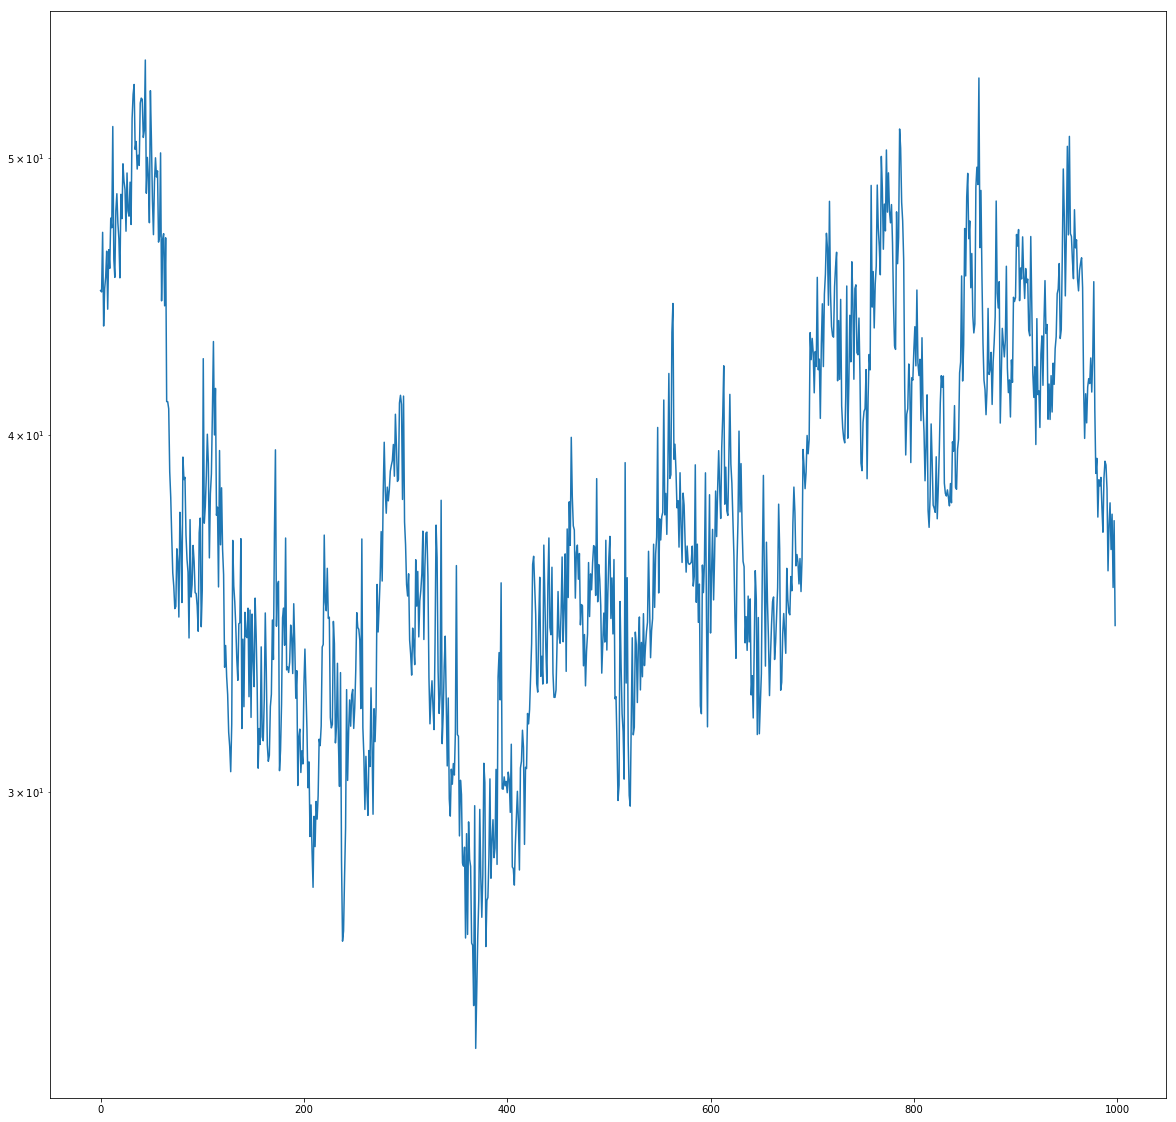

In [13]:
plt.figure(figsize=(20,20))
print(np.min(-chain.getLoglikes()))
print(np.argmin(-chain.getLoglikes()))
plt.semilogy(-chain.getLoglikes())

24.413425349833297
369


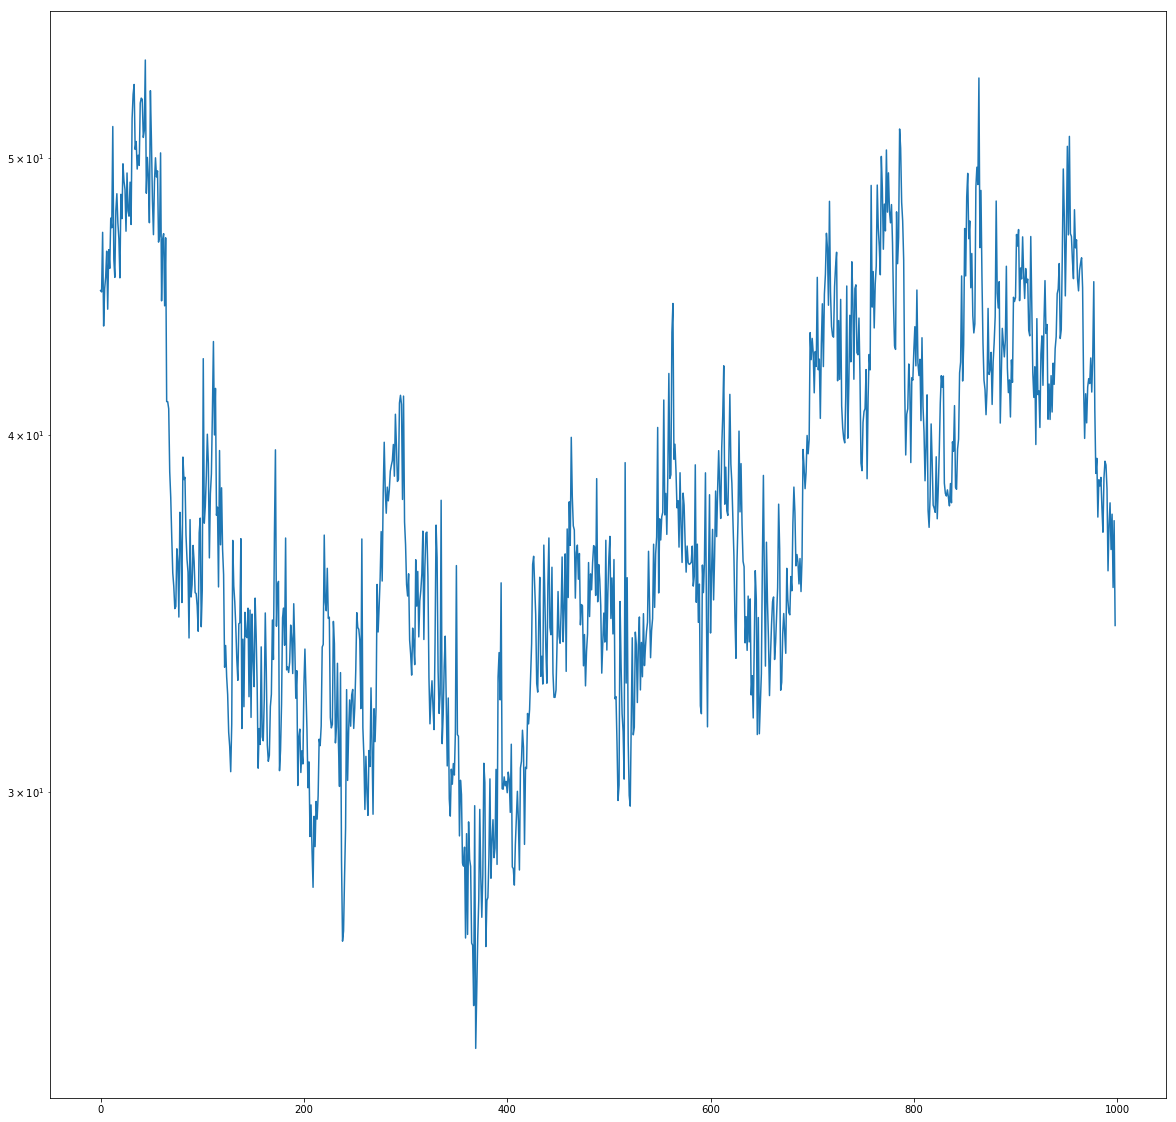

In [14]:

plt.figure(figsize=(20,20))
print(np.min(-chain.getLoglikes()))
print(np.argmin(-chain.getLoglikes()))
plt.semilogy(-chain.getLoglikes())

(152,)


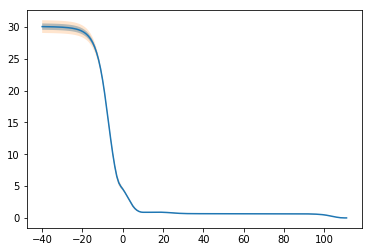

In [26]:
y = np.mean(chain.getSamples("R")[:,:],0)
print(y.shape)
plt.plot(time_all, y)
err = np.var(chain.getSamples("R"),0)**0.5
plt.fill_between(time_all, y-err, y+err,alpha=0.4)
plt.fill_between(time_all, y-2*err, y+2*err,alpha=0.2)

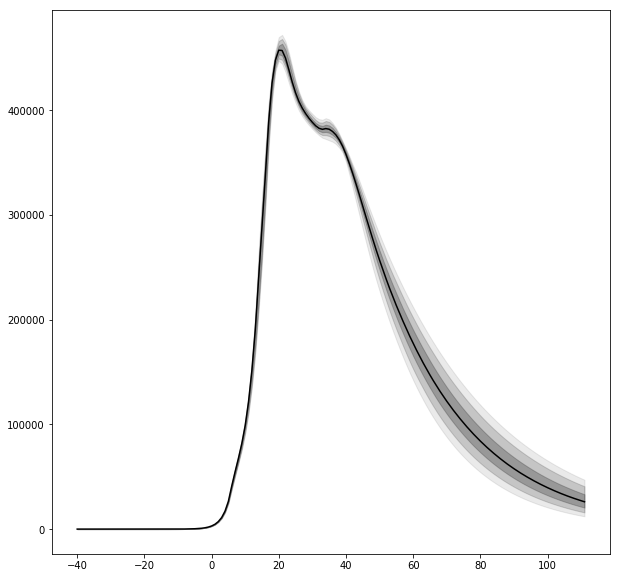

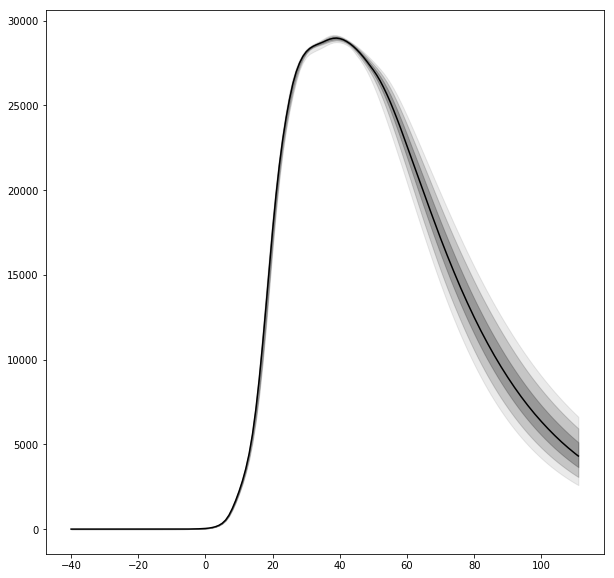

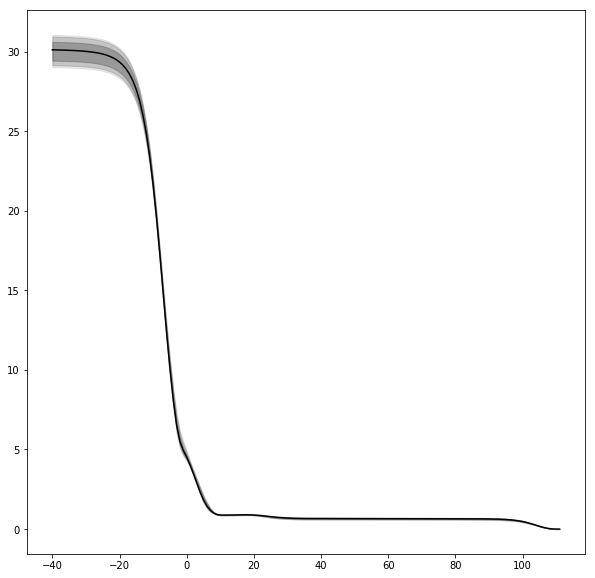

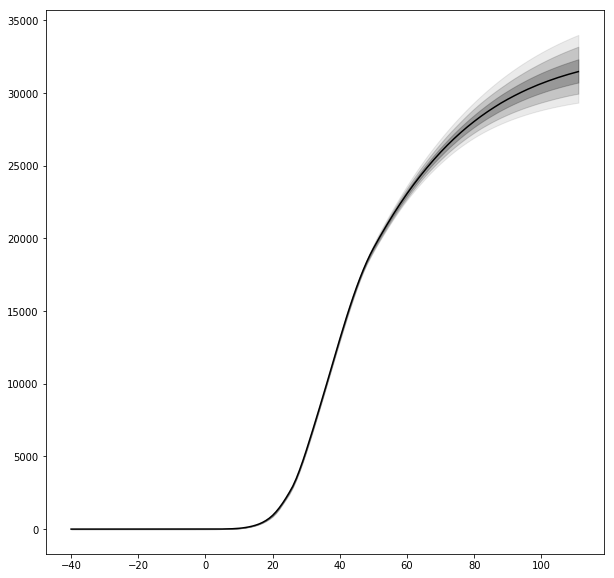

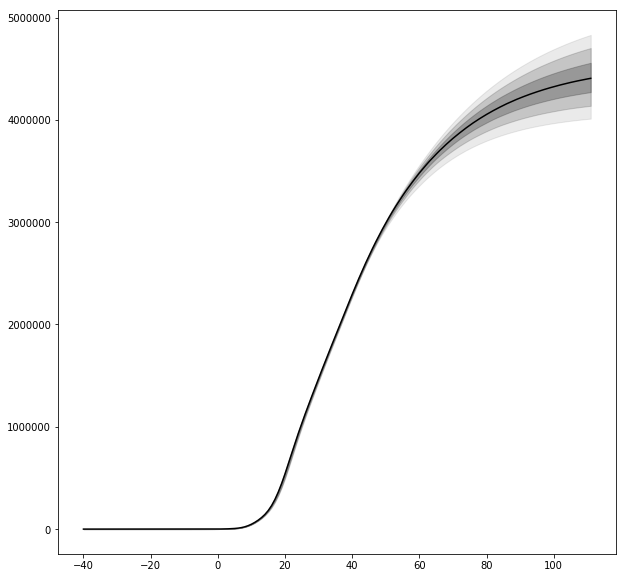

In [46]:
def myplot(name): 

    plt.figure(figsize=(10,10))
    y = np.median(chain.getSamples(name)[:,:],0)
    lower1 = np.percentile(chain.getSamples(name)[:,:], (100-68.27)/2, axis=0)
    lower2 = np.percentile(chain.getSamples(name)[:,:], (100-95.45)/2, axis=0)
    lower3 = np.percentile(chain.getSamples(name)[:,:], (100-99.73)/2, axis=0)
    upper1 = np.percentile(chain.getSamples(name)[:,:], 100-(100-68.27)/2, axis=0)
    upper2 = np.percentile(chain.getSamples(name)[:,:], 100-(100-95.45)/2, axis=0)
    upper3 = np.percentile(chain.getSamples(name)[:,:], 100-(100-99.73)/2, axis=0)
    plt.plot(time_all, y, 'k')
    fc = '#333333'
    ec = fc # '#000000'
    plt.fill_between(time_all, lower1, upper1, alpha=0.3, facecolor=fc, edgecolor=ec, antialiased=True)
    plt.fill_between(time_all, lower2, upper2, alpha=0.2, facecolor=fc, edgecolor=ec, antialiased=True)
    plt.fill_between(time_all, lower3, upper3, alpha=0.1, facecolor=fc, edgecolor=ec, antialiased=True)
    plt.show()
    
myplot("mild")
myplot("serious")
myplot("R")
myplot("dead")
myplot("recovered")

[28.06920919]
[3.55361395]
[5.05790383]
[0.38954454 0.37812302 0.17586628 0.146447  ]
[2.39284585]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.07627584e-08 6.39125053e-07 6.53616683e-06
 2.77384012e-05 7.74470060e-05 1.71013629e-04 3.16169961e-04
 5.45054200e-04 9.01260848e-04 1.44552688e-03 2.29521568e-03
 3.63326885e-03 5.71332935e-03 8.94265491e-03 1.39617399e-02
 2.17366987e-02 3.38000471e-02 5.25194952e-02 8.15593103e-02
 1.26597706e-01 1.96489438e-01 3.04920946e-01 4.73122905e-01
 7.34045220e-01 1.13880518e+00 1.76671668e+00 2.74078255e+00
 4.25181307e+00 6.59577420e+00 1.02317203e+01 1.58716031e+01
 2.45965155e+01 3.77553889e+01 5.66988363e+01 8.25678936e+01
 1.16091757e+02 1.58583599e+02 2.11262278e+02 2.75840211e+02
 3.55586392e+02 4.54371310e+02 5.75824755e+02 7

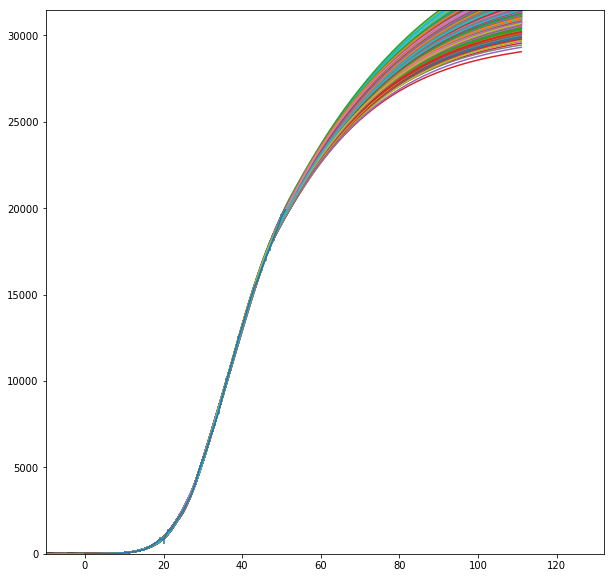

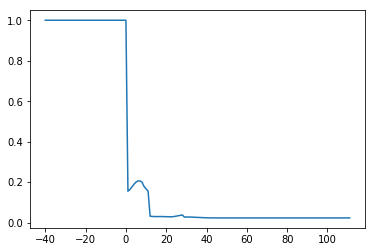

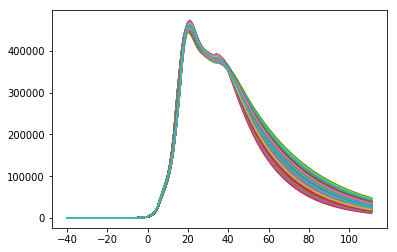

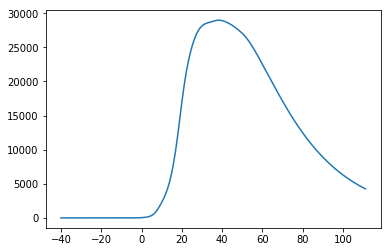

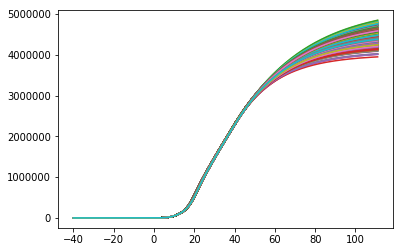

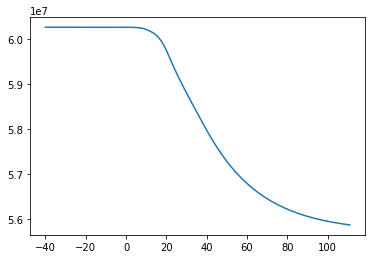

[3.03990601e+01 3.03946119e+01 3.03894755e+01 3.03835789e+01
 3.03767153e+01 3.03686539e+01 3.03591921e+01 3.03480879e+01
 3.03349645e+01 3.03193328e+01 3.03005663e+01 3.02779783e+01
 3.02507055e+01 3.02175311e+01 3.01768789e+01 3.01267855e+01
 3.00647105e+01 2.99872181e+01 2.98897305e+01 2.97663518e+01
 2.96091485e+01 2.94077598e+01 2.91481557e+01 2.88117532e+01
 2.83758325e+01 2.78099767e+01 2.70770175e+01 2.61336569e+01
 2.49318081e+01 2.34267867e+01 2.15884849e+01 1.94262327e+01
 1.70064773e+01 1.44651505e+01 1.19696495e+01 9.67228920e+00
 7.68480333e+00 6.10479658e+00 5.13150163e+00 4.65490420e+00
 4.35309801e+00 3.97877305e+00 3.52947409e+00 3.03274788e+00
 2.52615947e+00 2.04890930e+00 1.63462811e+00 1.30176706e+00
 1.05902273e+00 9.25870970e-01 8.81201118e-01 8.76751973e-01
 8.76352692e-01 8.77167257e-01 8.79104930e-01 8.82012038e-01
 8.85319924e-01 8.87879991e-01 8.88021126e-01 8.84006671e-01
 8.74585528e-01 8.59579414e-01 8.39775534e-01 8.16570082e-01
 7.91710314e-01 7.675388

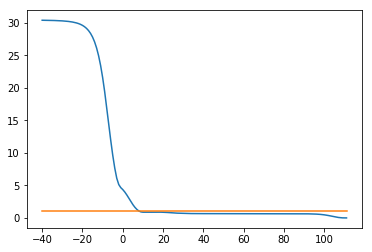

In [19]:
#plt.plot(time_all, chain.getMean("dead")[:] - np.mean(chain.getSamples("dead"),0))
#plt.show()
index = -1
print(chain.getSamples("delay")[index])
print(chain.getSamples("betaMild")[index])
print(chain.getSamples("betaHigh")[index])

print(chain.getSamples("discontinuousVals")[index])

print(chain.getSamples("missedDeaths")[index])


plt.figure(figsize=(10,10))
plt.plot(time_all, chain.getSamples("dead")[index,:])
print(chain.getSamples("dead")[index,:])
for i in range(chain.getSamples("dead").shape[0]): 
    plt.plot(time_all, chain.getSamples("dead")[i,:])


plt.errorbar(time_data, deaths_data, deaths_error)
plt.xlim([-10, deaths_data.size+80])

lims = plt.gca().get_xlim()
i = np.where( (time_all > lims[0]) &  (time_all < lims[1]) )[0]
plt.gca().set_ylim(chain.getSamples("dead")[index,i].min(), chain.getSamples("dead")[index,i].max() )

plt.show()


plt.plot(time_all, chain.getSamples("totalBehavior")[index,:])
plt.show()

plt.plot(time_all, chain.getSamples("mild")[index,:])
for i in range(chain.getSamples("mild").shape[0]): 
    plt.plot(time_all, chain.getSamples("mild")[i,:])
plt.show()



for i in range(chain.getSamples("mild").shape[0]): 
    plt.plot(time_all, chain.getSamples("mild")[i,:])
plt.show()
 
plt.plot(time_all, chain.getSamples("serious")[index,:])
plt.show()
 

plt.plot(time_all, chain.getSamples("recovered")[index,:])
for i in range(chain.getSamples("recovered").shape[0]): 
    plt.plot(time_all, chain.getSamples("recovered")[i,:])
plt.show()

plt.plot(time_all, nPop-chain.getSamples("recovered")[index,:])
plt.show()

print(chain.getSamples("R")[-1,:])
plt.plot(time_all, chain.getSamples("R")[-1,:])
plt.plot(time_all, np.ones(time_all.shape))
plt.show()

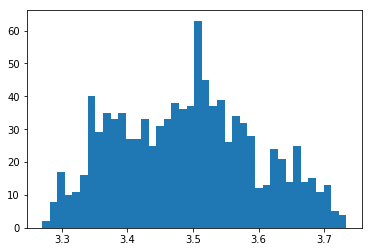

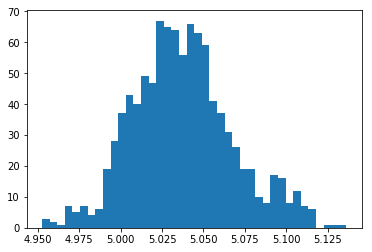

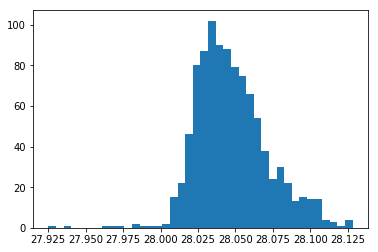

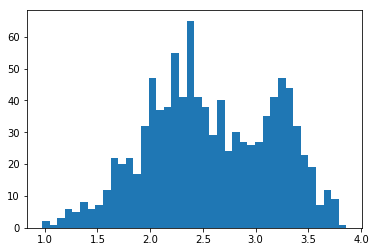

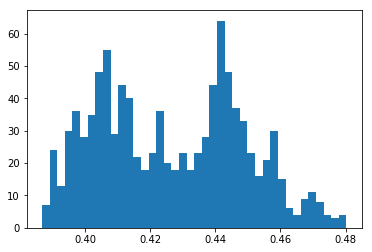

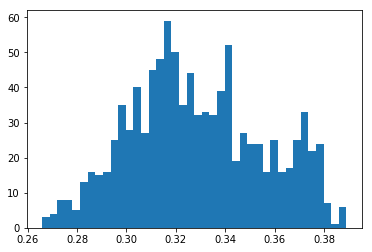

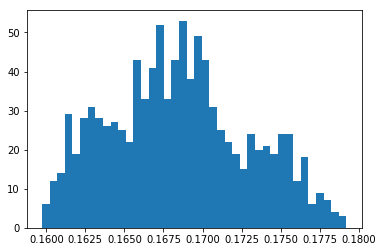

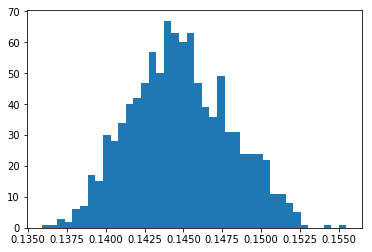

In [29]:
begin = 0
end = -1

plt.hist(chain.getSamples("betaMild")[begin:end], 40)
plt.show()
plt.hist(chain.getSamples("betaHigh")[begin:end], 40)
plt.show()

plt.hist(chain.getSamples("delay")[begin:end], 40)
plt.show()
plt.hist(chain.getSamples("missedDeaths")[begin:end], 40)
plt.show()

plt.hist(chain.getSamples("discontinuousVals")[begin:end, 0], 40)
plt.show()
plt.hist(chain.getSamples("discontinuousVals")[begin:end, 1], 40)
plt.show()
plt.hist(chain.getSamples("discontinuousVals")[begin:end, 2], 40)
plt.show()
plt.hist(chain.getSamples("discontinuousVals")[begin:end, 3], 40)
plt.show()

# 3.285           3.1         3.38
# 7.295         5.15           5.05 
# 25.051          28.03       28.04
# 0.005          0.35         0.05
 
# 0.382         0.45        0.44
# 0.264         0.35        0.35
# 0.1576        0.16        0.152
# 0.1515        0.15        0.139

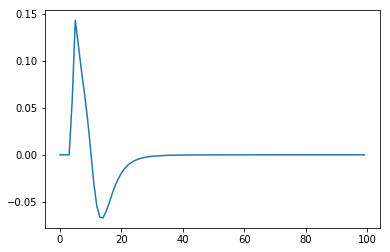

In [62]:
params = mcmc.DiseaseParams()
params.probLethalDailyWhenSeriousUntreated = 0.4
params.probSerious = 0.04 #unknown, higher for older population - should be possible to extract from Diamond Princess. 
#I think about 30 were serious... 30/700 would then be upper limit, so at most 5% for old people. 
#Conistency check: 6(factor below)*11(dead on diamond princess) = 66... okay, more than 30. So 10% serious for old people.
# this number is between 0.02 and 0.1. need to line search max likelihood

params.probLethal = 0.01 #out of 50~49 serious cases, 7 dead in Aachen study https://www.aerzteblatt.de/archiv/213454
params.probAsymp = 0.3
params.timeIncub = 6  #chinese like studies...
params.timeIncubSigma = 4

#obained to match median 4, IQR 7 from Aachen study https://www.aerzteblatt.de/archiv/213454
params.timeMildToSerious = 7.1 
params.timeMildToSeriousSigma = 13

#Drosten study https://www.medrxiv.org/content/10.1101/2020.03.05.20030502v1 
#: 9 patients, all virus present after 5 days of symptoms. Let's say then that chance shorter ~ 10%. 
# seroconversion early week 2 progressive decrease in viral load in samples. 10 days most gone. 
#let's take lognormal with 5 at 10% CDF and 10 at 90% CDF 
params.timeMildDuration = 7.4 
params.timeMildDurationSigma = 2

# Aachen Median acht Tage (IQR 5–11) for all, including most that did not die. 
# This is longer with larger spread than the recovered group. We choose Median 8.6, IQR 6.6 to get 
params.timeSeriousToDeath = 10
params.timeSeriousToDeathSigma = 6

# less important: 
# Aachen Median 7 Tage [IQR 6–11])
params.timeSeriousToRecovered = 8
params.timeSeriousToRecoveredSigma = 4.5




traj = mcmc.AvgDiseaseTrajectory(params)

b=np.zeros(100)
for i in range(100):
    b[i]=traj.getMild(i)
plt.plot(b)

In [ ]:
n1 = 6
n2 = 5
n3 = 4
n4 = 5

# (array([1, 1, 2, 3, 4]), array([3, 3, 3, 1, 1]), array([0, 1, 0, 1, 1]), array([0, 0, 0, 0, 0]))
#winner is first, 1 3 0 0. Second is fourth, 3 1 1 0. 
#
# for i1, probSerious in enumerate(np.linspace(0.02, 0.06, n1)):
#     for i2, probAsymp in enumerate(np.linspace(0.1, 0.4, n2)):
#         for i3, hosp in enumerate(np.linspace(10, 100, n3)): 
#             for i4, probLethalIfSerious in enumerate(np.linspace(0.14, 0.1922, n4)):

# 1 loop: (array([2, 3, 3, 5]), array([4, 2, 2, 3]), array([1, 1, 3, 1]), array([4, 2, 3, 1]))
# winner is last, 5 3 1 1, second is third, 3 2 3 3 
# 4 loops: 
#(array([5, 5, 5, 5]), array([2, 3, 3, 3]), array([2, 0, 1, 2]), array([0, 0, 1, 1]))
# 5 3 0 0 best, 5 3 1 1 and 5 2 2 0 second 
#(array([1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 5, 5, 5, 5, 5, 5]), array([2, 4, 3, 3, 3, 4, 4, 2, 3, 3, 3, 3, 3, 2, 2, 2, 3, 3, 3]), array([0, 1, 0, 0, 1, 0, 1, 3, 0, 1, 2, 0, 0, 0, 2, 3, 0, 1, 2]), array([3, 2, 2, 4, 3, 4, 4, 3, 1, 2, 0, 0, 1, 3, 0, 1, 0, 1, 1]))
#
# for i1, probSerious in enumerate(np.linspace(0.02, 0.045, n1)):
#     for i2, probAsymp in enumerate(np.linspace(0.15, 0.45, n2)):
#         for i3, hosp in enumerate(np.linspace(10, 40, n3)): 
#             for i4, probLethalIfSerious in enumerate(np.linspace(0.13, 0.17, n4)):
res = np.zeros((n1,n2,n3,n4))

g1 = np.linspace(0.02, 0.045, n1)
g2 = np.linspace(0.15, 0.45, n2)
g3 = np.linspace(10, 40, n3)
g4 = np.linspace(0.13, 0.17, n4)

for i1, probSerious in enumerate(np.linspace(0.02, 0.045, n1)):
    for i2, probAsymp in enumerate(np.linspace(0.15, 0.45, n2)):
        for i3, hosp in enumerate(np.linspace(10, 40, n3)): 
            for i4, probLethalIfSerious in enumerate(np.linspace(0.13, 0.17, n4)):
                
                l, chain = loglike(probSerious, probAsymp, hosp, probLethalIfSerious)
                res[i1,i2,i3,i4] = l
                
                
                

(array([5, 5, 5]), array([2, 3, 3]), array([2, 0, 1]), array([0, 0, 1]))
-1.3911191126645892


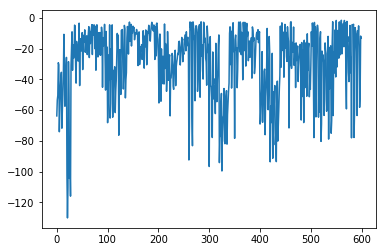

In [37]:
print(np.where(res > 1.2*np.max(res)))
print(np.max(res))
plt.plot(res.flatten())


[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.44229176e-12 3.00023557e-07
 5.20009284e-06 2.45113659e-05 7.13740344e-05 1.63387810e-04
 3.13279564e-04 5.70833936e-04 1.01524752e-03 1.76365140e-03
 3.02939987e-03 5.17280073e-03 8.78075499e-03 1.48614794e-02
 2.51180122e-02 4.23815756e-02 7.14566758e-02 1.20424624e-01
 2.02894292e-01 3.41771044e-01 5.75671708e-01 9.69579144e-01
 1.63292711e+00 2.75001941e+00 4.63120552e+00 7.79906202e+00
 1.31136854e+01 2.17415748e+01 3.50051766e+01 5.42895530e+01
 8.09565605e+01 1.17246972e+02 1.65799237e+02 2.30181384e+02
 3.15890626e+02 4.28874699e+02 5.73542190e+02 7.52647752e+02
 9.65596570e+02 1.21109135e+03 1.48527173e+03 1.78283424e+03
 2.10209479e+03 2.441146

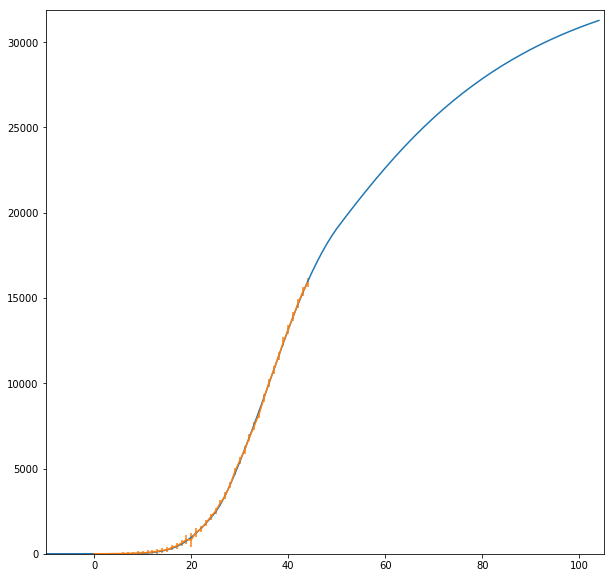

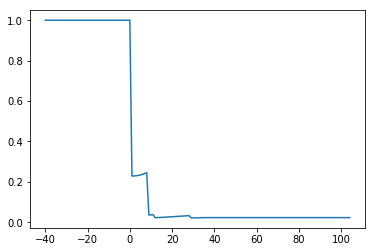

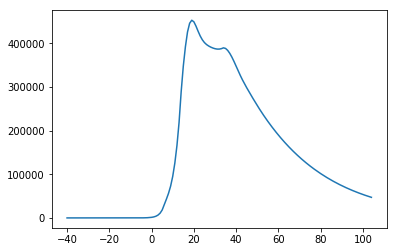

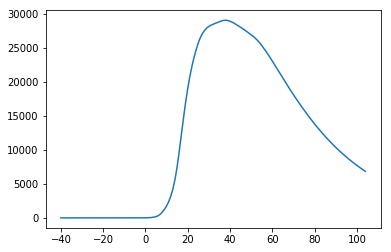

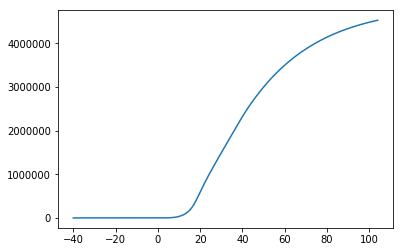

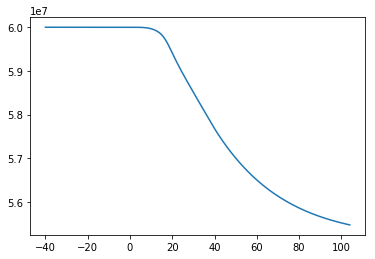

In [39]:
#plt.plot(time_all, chain.getMean("dead")[:] - np.mean(chain.getSamples("dead"),0))
#plt.show()

plt.figure(figsize=(10,10))
plt.plot(time_all, chain.getSamples("dead")[-1,:])
print(chain.getSamples("dead")[-1,:])
#for i in range(110): 
#    plt.plot(time_all, chain.getSamples("dead")[-1-35*i,:])


plt.errorbar(time_data, deaths_data, deaths_error)
plt.xlim([-10, deaths_data.size+60])

lims = plt.gca().get_xlim()
i = np.where( (time_all > lims[0]) &  (time_all < lims[1]) )[0]
plt.gca().set_ylim( chain.getMean("dead")[i].min(), chain.getMean("dead")[i].max() )

plt.show()


plt.plot(time_all, chain.getSamples("totalBehavior")[-1,:])
plt.show()

plt.plot(time_all, chain.getSamples("mild")[-1,:])
plt.show()
 
plt.plot(time_all, chain.getSamples("serious")[-1,:])
plt.show()
 

plt.plot(time_all, chain.getSamples("recovered")[-1,:])
plt.show()

plt.plot(time_all, nPop-chain.getSamples("recovered")[-1,:])
plt.show()